In [10]:
%pylab inline
from lib import price_utils
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
reload(price_utils)
pd.options.display.float_format = '£{:,.2f}'.format


month = '2016-09-01'

Populating the interactive namespace from numpy and matplotlib


# Top ccg-presentation savings

The SQL for this is abstracted into the `price_utils` library, q.v. for details.

We normalise prescriptions to their generic equivalent (where possible), and exclude specials.

The following is sorted by possible savings at the top decile. It tells us that CCG 03C (NHS Leeds West) had the single biggest saving opportunity: to save £13,500 on its purchase of 60 Sucralfate Enemas. It paid £238 per dose, when the lowest decile paid £12 per dose.

In [30]:
top_1000_ccg = price_utils.get_savings(group_by='ccg', month=month, limit=1000)

In [31]:
top_1000_ccg.head()

,bnf_presentation,pct,generic_presentation,category,brand_count,lowest_decile,quantity,price_per_dose,possible_savings
0,Influenza_Vac Inact 0.5ml Pfs,13T,1404000H0AAAFAF,NP8,4,£5.42,25993,£7.17,"£45,400.58"
1,Fluticasone/Salmeterol_Inh 250/25mcg120D,13P,0302000N0AABGBG,C,3,£41.34,3176,£54.77,"£42,648.70"
2,Glycopyrronium Brom_Inh Cap 55mcg + Dev,06M,0301020S0AAAAAA,C,2,£0.85,23404,£2.34,"£34,835.68"
3,Fluticasone/Salmeterol_Inh 250/25mcg120D,01H,0302000N0AABGBG,C,3,£41.34,2534,£53.62,"£31,115.91"
4,Fluticasone/Salmeterol_Inh 250/25mcg120D,09G,0302000N0AABGBG,C,3,£41.34,2221,£55.06,"£30,467.31"


How do the savings break down by Tariff Part VIII?

In [32]:
top_1000_ccg.to_csv("ccgs-%s.csv" % month)
top_1000_ccg.groupby('category')['possible_savings'].sum()

category
A      £327,402.64 
C     £5,145,215.56
M      £706,877.37 
NP8   £1,994,532.36
Name: possible_savings, dtype: float64

## Grouped by CCG

The same data as above, but grouped by CCG

In [46]:
by_ccg = top_1000_ccg.groupby('pct')['possible_savings'] \
  .agg({'Count': 'count', 'Total savings': 'sum'}).sort_values('Total savings', ascending=False)
by_ccg.head()

,Count,Total savings
pct,,
13T,19,"£43,610.21"
09G,19,"£41,909.08"
13P,22,"£36,183.68"
06K,20,"£35,381.27"
06M,14,"£33,997.24"


In [48]:
by_ccg['Total savings'].sum()

1834776.1019753087

## Just focusing on Rich's CCG

In [17]:
by_ccg.loc('savings_presentations_pct')['99P']

Count               18.00000
Total savings    25500.47132
Name: 99P, dtype: float64

In [50]:
asd = price_utils.get_savings(for_entity='99P', month=month, limit=None)

In [51]:
asd.sort_values('possible_savings', ascending=False)

,bnf_presentation,pct,generic_presentation,category,brand_count,lowest_decile,quantity,price_per_dose,possible_savings
0,Budesonide/Formoterol Inh B/A 200/6(120D,99P,0302000K0AAAMAM,C,3,£27.77,5050,£33.79,"£30,403.29"
1,Pregabalin_Cap 300mg,99P,0408010AEAAAGAG,C,3,£0.75,94022,£1.04,"£27,277.49"
2,Pregabalin_Cap 150mg,99P,0408010AEAAAEAE,C,3,£0.75,89725,£1.03,"£25,363.10"
3,Fluticasone/Salmeterol_Inh 125/25mcg120D,99P,0302000N0AABFBF,C,3,£24.33,3215,£32.06,"£24,855.16"
4,Budesonide/Formoterol Inh B/A 400/12(60D,99P,0302000K0AAAUAU,C,3,£27.77,3820,£33.66,"£22,467.97"
5,Pregabalin_Cap 75mg,99P,0408010AEAAACAC,C,3,£0.75,81897,£1.01,"£21,674.28"
6,Influenza_Vac Inact 0.5ml Pfs,99P,1404000H0AAAFAF,None,7,£5.42,35736,£5.96,"£19,183.95"
7,Beclomet Diprop_Inha 100mcg (200 D) CFF,99P,0302000C0AABFBF,None,3,£6.88,6015,£9.98,"£18,636.36"
8,Pregabalin_Cap 50mg,99P,0408010AEAAABAB,C,3,£0.75,57646,£1.02,"£15,530.64"
9,Methocarbamol_Tab 750mg,99P,1002020S0AAABAB,A,2,£0.12,43763,£0.46,"£14,894.49"


In [4]:
# Save it to a cSV

asd.to_csv("99P-full-%s.csv" % month)

# Same thing for practices

In [66]:
top_1000_practice = price_utils.get_savings(group_by='practice',month=month, limit=1000)

In [67]:
top_1000_practice.head()


,bnf_presentation,practice,pct,generic_presentation,category,brand_count,lowest_decile,quantity,price_per_dose,possible_savings
0,Sucralfate_Enem 2g In 50ml,B86030,03C,0107010S0AAAGAG,NP8,1,£11.63,60,£237.63,"£13,560.25"
1,"Dalteparin Sod_Inj 25,000u/ml 0.72ml Pfs",K84055,10Q,0208010L0AAAIAI,NP8,1,£9.42,110,£127.30,"£12,967.45"
2,Melatonin_Cap 2mg,Y05181,01X,0401010ADAAAEAE,NP8,1,£0.67,17566,£1.34,"£11,681.95"
3,Sod Phenylbut_Liq Spec 1.25g/5ml,J82034,11A,0908010P0AAAEAE,NP8,1,£1.01,2500,£5.15,"£10,364.86"
4,None,E83638,07M,0908010S0AAACAC,NP8,1,£21.23,400,£46.31,"£10,035.05"


In [8]:

top_1000_practice.to_csv("practices-%s.csv" % month)

# What is the distribution of the easiest cost savings?

For each practice, compute and sum its top three savings, then plot these in a histogram.

In [99]:
reload(price_utils)
top_10 = price_utils.top_savings_per_entity(top_n=10, entity='practice')

In [100]:
top_10.describe()

,top_savings_sum
count,"£9,759.00"
mean,"£1,802.69"
std,"£1,627.04"
min,£-257.59
25%,£597.54
50%,"£1,531.96"
75%,"£2,606.13"
max,"£17,495.97"


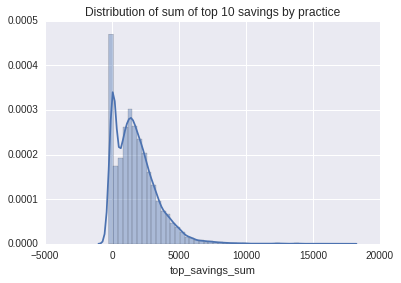

In [101]:
sns.distplot(top_10.top_savings_sum)
plt.title("Distribution of sum of top 10 savings by practice")
plt.show()

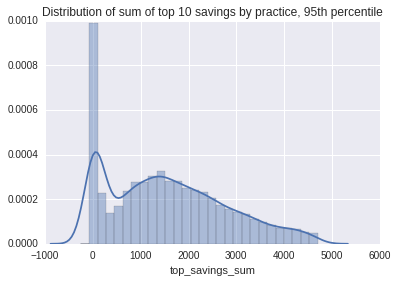

In [102]:
asd = top_10[top_10.top_savings_sum < top_10.top_savings_sum.quantile(.95)]
g = sns.distplot(asd.top_savings_sum)
plt.title("Distribution of sum of top 10 savings by practice, 95th percentile")
plt.show()

In [104]:
top_10_pct = price_utils.top_savings_per_entity(top_n=10, entity='pct')

In [105]:
top_10_pct.describe()

,top_savings_sum
count,£387.00
mean,"£4,356.97"
std,"£4,156.72"
min,£-14.85
25%,£175.46
50%,"£4,725.19"
75%,"£6,961.41"
max,"£20,550.91"


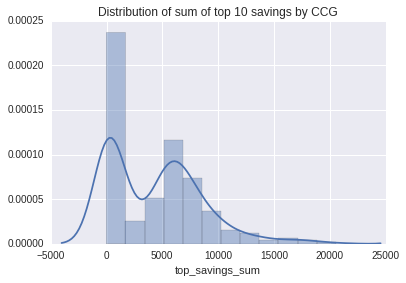

In [107]:
sns.distplot(top_10_pct.top_savings_sum)
plt.title("Distribution of sum of top 10 savings by CCG")
plt.show()